Spectrogram code extracted from: https://github.com/vijay033/Noise-Suppression-Auto-Encoder/blob/master/ProcessWav.ipynb

In [64]:
# TensorFlow Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Cropping2D, ZeroPadding2D
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

# Other
import os
import glob
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
from IPython.display import Audio

## Spectrogram Functions

In [2]:
def amplifyMagnitudeByLog(d):
    return 188.301 * math.log10(d + 1)

def weakenAmplifiedMagnitude(d):
    return math.pow(10, d/188.301)-1

def recoverLinearScale(rgbArray, magnitudeMin, magnitudeMax, phaseMin, phaseMax):
    width = rgbArray.shape[1]
    height = rgbArray.shape[0]
    # print(phaseMax,phaseMin)
    magnitudeVals = rgbArray[:,:,0].astype(float) + rgbArray[:,:,1].astype(float)
    phaseVals = rgbArray[:,:,2].astype(float)
    phaseRange = phaseMax - phaseMin
    magnitudeRange = magnitudeMax - magnitudeMin
    
    for w in range(width):
        for h in range(height):
            phaseVals[h,w] = (phaseVals[h,w] / 255 * phaseRange) + phaseMin
            magnitudeVals[h,w] = weakenAmplifiedMagnitude(magnitudeVals[h,w])
            magnitudeVals[h,w] = (magnitudeVals[h,w] / (255*2) * magnitudeRange) + magnitudeMin
    return magnitudeVals, phaseVals

def recoverSignalFromSpectrogram(numpyarray):
    data = np.array(numpyarray, dtype='uint8')
    width = data.shape[1]
    height = data.shape[0]

    magnitudeVals, phaseVals = recoverLinearScale(data, magnitudeMin, magnitudeMax, phaseMin, phaseMax)
        
    recovered = np.zeros(WINDOW_LENGTH * width // 2 + WINDOW_STEP, dtype=np.int16)
    recovered = np.array(recovered,dtype=np.int16)
    
    for w in range(width):
        toInverse = np.zeros(height, dtype=np.complex_)
        for h in range(height):
            magnitude = magnitudeVals[height-h-1,w]
            phase = phaseVals[height-h-1,w]
            toInverse[h] = magnitude * math.cos(phase) + (1j * magnitude * math.sin(phase))
        signal = np.fft.irfft(toInverse)
        recovered[w*WINDOW_STEP:w*WINDOW_STEP + WINDOW_LENGTH] += signal[:WINDOW_LENGTH].astype(np.int16)
    return recovered


# Use these initializations for recovery from spectrogram
FFT_LENGTH = 512
WINDOW_LENGTH = 512
WINDOW_STEP = int(WINDOW_LENGTH / 2)
phaseMax = 3.141592653589793 
phaseMin = -3.141592653589793
magnitudeMax = 2211683.973249525
magnitudeMin = 0.0
rate = 16000

## Data Loading

In [3]:
files_train = glob.glob("/data/csc6621/24-team-c/dataset/LibriNoise_Train_Test_NPY/mat_train/*.npy")
files_train_y = glob.glob("/data/csc6621/24-team-c/dataset/LibriNoise_Train_Test_NPY/mat_ytrain/*.npy")
files_test = glob.glob("/data/csc6621/24-team-c/dataset/LibriNoise_Train_Test_NPY/mat_test/*.npy")
files_test_y = glob.glob("/data/csc6621/24-team-c/dataset/LibriNoise_Train_Test_NPY/mat_ytest/*.npy")

In [4]:
class SpectrogramDataGenerator(keras.utils.Sequence):
    def __init__(self, X_paths, y_paths, batch_size):
        self.X_paths = X_paths
        self.y_paths = y_paths
        self.batch_size = batch_size
        self.indices = np.arange(len(self.X_paths))

    def __len__(self):
        return int(np.ceil(len(self.X_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size : (idx + 1) * self.batch_size]
        X_batch = []
        y_batch = []
        for i in batch_indices:
            X_batch.append(np.load(self.X_paths[i])/255)
            y_batch.append(np.load(self.y_paths[i])/255)
        return np.array(X_batch), np.array(y_batch)

In [5]:
data = SpectrogramDataGenerator(files_train, files_train_y, batch_size=128)

## Model

In [6]:
K.clear_session()

In [7]:
INPUT_DIM = (257, 62, 3)

In [8]:
# class Autoencoder(Model):
#     def __init__(self):
#         super(Autoencoder, self).__init__()

#         self.encoder = tf.keras.Sequential([
#             layers.Input(shape=INPUT_DIM),
#             layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#             #layers.MaxPooling2D((2, 2), padding='same'),
#             layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#             #layers.MaxPooling2D((2, 2), padding='same'),
#             layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#             #layers.MaxPooling2D((2, 2), padding='same'),
#         ])

#         self.decoder = tf.keras.Sequential([
#             layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
#             layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
#             layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
#             layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

In [9]:
# ae = Autoencoder()
# ae.compile(optimizer='adam', loss='mean_squared_error')
# ae.build(input_shape=(None, *INPUT_DIM))
# ae.summary()

In [10]:
# ae.fit(data, epochs=1)

In [74]:
def unet(input_size):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    #conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    padded1 = ZeroPadding2D(padding=((0, 0), (0, 1)))(pool1) # Deal with odd dimensions
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(padded1)
    #conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    #conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    #conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    #drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    #conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    #drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    crop_conv4 = Cropping2D(cropping=((0, 0), (0, 0)))(conv4)
    merge6 = concatenate([crop_conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    #conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2DTranspose(256, 2, strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    crop_conv3 = Cropping2D(cropping=((0, 0), (0, 0)))(conv3)
    merge7 = concatenate([crop_conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    #conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2DTranspose(128, 2, strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    crop_conv2 = Cropping2D(cropping=((0, 0), (0, 0)))(conv2)
    merge8 = concatenate([crop_conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    #conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2DTranspose(64, 2, strides=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    crop_up9 = Cropping2D(cropping=((0, 0), (0, 2)))(up9)
    pad_up9 = ZeroPadding2D(padding=((1, 0), (0, 0)))(crop_up9)
    merge9 = concatenate([conv1, pad_up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    #conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    # Output
    conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)
    
    return model

In [12]:
un = unet(input_size=INPUT_DIM)
#opt = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
reduce_lr = ReduceLROnPlateau(patience=3, monitor='loss') # try min_delta=0.0003 ?
un.compile(optimizer='adam', loss='mean_squared_error')
un.summary()

2024-04-22 17:52:49.703946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13797 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:db:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 257, 62, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 257, 62, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 31, 64)  0           ['conv2d[0][0]']                 
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 128, 32, 64)  0          ['max_pooling2d[0][0]']      

In [13]:
history = un.fit(data,
                 epochs=30,
                 callbacks=[reduce_lr])

Epoch 1/30


2024-04-22 17:52:50.639009: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-22 17:52:52.420938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2024-04-22 17:53:01.264757: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55bf4b1df1d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-22 17:53:01.264797: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-04-22 17:53:01.269385: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-22 17:53:01.407455: I ./tensor

55/55 [==============================] - 116s 2s/step - loss: 0.0430 - lr: 0.0010
Epoch 2/30
55/55 [==============================] - 60s 1s/step - loss: 0.0323 - lr: 0.0010
Epoch 3/30
55/55 [==============================] - 48s 868ms/step - loss: 0.0317 - lr: 0.0010
Epoch 4/30
55/55 [==============================] - 48s 868ms/step - loss: 0.0313 - lr: 0.0010
Epoch 5/30
55/55 [==============================] - 48s 869ms/step - loss: 0.0311 - lr: 0.0010
Epoch 6/30
55/55 [==============================] - 48s 868ms/step - loss: 0.0312 - lr: 0.0010
Epoch 7/30
55/55 [==============================] - 48s 868ms/step - loss: 0.0311 - lr: 0.0010
Epoch 8/30
55/55 [==============================] - 48s 868ms/step - loss: 0.0308 - lr: 0.0010
Epoch 9/30
55/55 [==============================] - 48s 868ms/step - loss: 0.0308 - lr: 0.0010
Epoch 10/30
55/55 [==============================] - 48s 868ms/step - loss: 0.0305 - lr: 0.0010
Epoch 11/30
55/55 [==============================] - 48s 868ms/st

## Testing

In [14]:
test_data = SpectrogramDataGenerator(files_test, files_test_y, batch_size=1)

In [81]:
n = 24
X_test, y_test = test_data[n]
pred = un.predict(X_test)

1/1 [==============================] - 0s 25ms/step


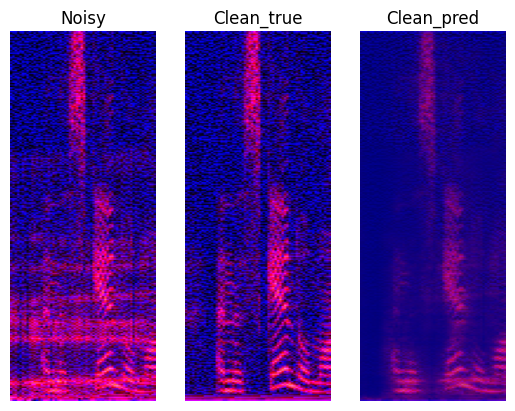

In [83]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(X_test[0], aspect='auto')
axes[0].set_axis_off()
axes[0].set_title('Noisy')
axes[1].imshow(y_test[0], aspect='auto')
axes[1].set_axis_off()
axes[1].set_title('Clean_true')
axes[2].imshow(pred[0], aspect='auto')
axes[2].set_axis_off()
axes[2].set_title('Clean_pred')
plt.show()

In [84]:
noisy_wav = recoverSignalFromSpectrogram(X_test[0] * 255)
clean_wav = recoverSignalFromSpectrogram(y_test[0] * 255)
pred_wav = recoverSignalFromSpectrogram(pred[0] * 255)

In [85]:
Audio(data=noisy_wav, rate=rate)

In [86]:
Audio(data=clean_wav, rate=rate)

In [87]:
Audio(data=pred_wav, rate=rate)

## Save All

In [71]:
experiment_name = 'UNET-med-30epoch'
for idx, pair in tqdm(enumerate(test_data), total=len(test_data)):
    X_test, y_test = pair
    pred = un.predict(X_test, verbose=0)
    noisy_wav = recoverSignalFromSpectrogram(X_test[0] * 255)
    clean_wav = recoverSignalFromSpectrogram(y_test[0] * 255)
    pred_wav = recoverSignalFromSpectrogram(pred[0] * 255)
    
    wavfile.write(f'outputs/{experiment_name}/{idx}_noisy.wav', rate, noisy_wav)
    wavfile.write(f'outputs/{experiment_name}/{idx}_clean.wav', rate, clean_wav)
    wavfile.write(f'outputs/{experiment_name}/{idx}_pred.wav', rate, pred_wav)

100%|██████████| 105/105 [00:25<00:00,  4.06it/s]
